In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vamos import optimize, OptimizeConfig, NSGAIIConfig, make_problem_selection
from vamos.foundation.problem.binary import (
    BinaryKnapsackProblem,
    BinaryFeatureSelectionProblem,
    BinaryQUBOProblem,
)
from vamos.foundation.problem.tsp import TSPProblem

plt.style.use("ggplot")
print("Discrete encoding problems loaded!")

Discrete encoding problems loaded!


## 1. Binary Encoding

Binary variables represent yes/no decisions. Common operators:
- **Crossover**: Uniform, one-point, two-point
- **Mutation**: Bit-flip

### 1.1 Binary Knapsack Problem

In [2]:
# Create binary knapsack problem
knapsack = BinaryKnapsackProblem(n_var=20, capacity_ratio=0.4)

print(f"Problem: Binary Knapsack")
print(f"  Variables: {knapsack.n_var} items (binary: include or not)")
print(f"  Objectives:")
print(f"    - f1: Deviation from capacity (minimize)")
print(f"    - f2: Negative total value (minimize → maximize value)")
print(f"  Capacity: {knapsack.capacity:.2f}")
print(f"  Encoding: {knapsack.encoding}")

Problem: Binary Knapsack
  Variables: 20 items (binary: include or not)
  Objectives:
    - f1: Deviation from capacity (minimize)
    - f2: Negative total value (minimize → maximize value)
  Capacity: 44.16
  Encoding: binary


In [3]:
# Configure NSGA-II for binary encoding
binary_config = (
    NSGAIIConfig()
    .pop_size(50)
    .crossover("uniform", prob=0.9)  # Uniform crossover for binary
    .mutation("bitflip", prob=0.05)  # Bit-flip mutation
    .selection("tournament", pressure=2)
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

# Run optimization
knapsack_result = optimize(OptimizeConfig(
    problem=knapsack,
    algorithm="nsgaii",
    algorithm_config=binary_config,
    termination=("n_eval", 3000),
    seed=42,
))

print(f"Found {len(knapsack_result.F)} Pareto-optimal solutions")

Found 50 Pareto-optimal solutions


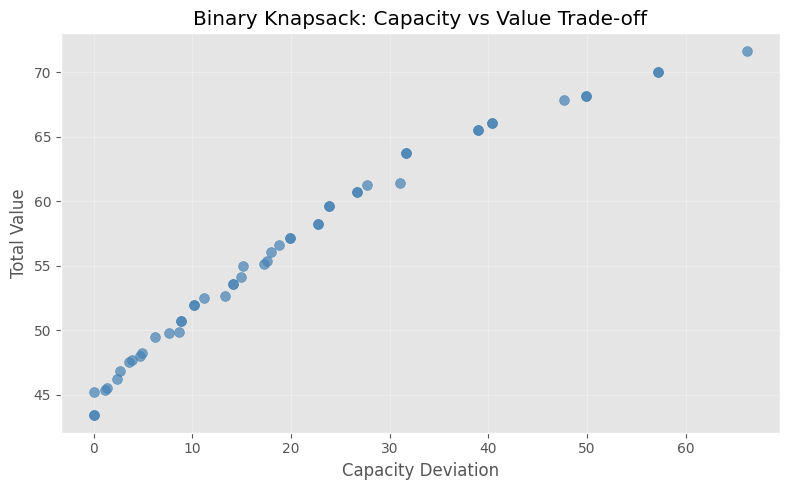

In [4]:
# Visualize: capacity deviation vs value
fig, ax = plt.subplots(figsize=(8, 5))

# f2 is negative value, so negate for display
ax.scatter(knapsack_result.F[:, 0], -knapsack_result.F[:, 1], s=50, alpha=0.7, c='steelblue')
ax.set_xlabel("Capacity Deviation")
ax.set_ylabel("Total Value")
ax.set_title("Binary Knapsack: Capacity vs Value Trade-off")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Analyze solutions
print("Sample solutions:")
print("-" * 50)

for i in [0, len(knapsack_result.F)//2, -1]:
    bits = (knapsack_result.X[i] > 0.5).astype(int)
    selected = np.where(bits)[0]
    weight = bits @ knapsack.weights
    value = bits @ knapsack.values
    
    print(f"Solution {i+1}:")
    print(f"  Items selected: {len(selected)} ({selected[:8]}{'...' if len(selected) > 8 else ''})")
    print(f"  Total weight: {weight:.2f} (capacity: {knapsack.capacity:.2f})")
    print(f"  Total value: {value:.2f}")
    print()

Sample solutions:
--------------------------------------------------
Solution 1:
  Items selected: 11 ([ 0  1  2  3  5  9 10 12]...)
  Total weight: 44.17 (capacity: 44.16)
  Total value: 43.47

Solution 26:
  Items selected: 13 ([ 0  1  2  5  7  9 10 11]...)
  Total weight: 59.06 (capacity: 44.16)
  Total value: 54.15

Solution 0:
  Items selected: 11 ([ 0  1  2  3  5  7  9 10]...)
  Total weight: 45.30 (capacity: 44.16)
  Total value: 45.36



### 1.2 Binary QUBO Problem

Quadratic Unconstrained Binary Optimization - common in combinatorial optimization.

In [6]:
# Create QUBO problem
qubo = BinaryQUBOProblem(n_var=15)

print(f"Problem: Binary QUBO")
print(f"  Variables: {qubo.n_var}")
print(f"  Objectives:")
print(f"    - f1: Quadratic energy x'Qx + b'x (minimize)")
print(f"    - f2: Negative bit count (minimize → maximize selected bits)")

# Run optimization
qubo_result = optimize(OptimizeConfig(
    problem=qubo,
    algorithm="nsgaii",
    algorithm_config=binary_config,
    termination=("n_eval", 2000),
    seed=42,
))

print(f"\nFound {len(qubo_result.F)} Pareto-optimal solutions")

Problem: Binary QUBO
  Variables: 15
  Objectives:
    - f1: Quadratic energy x'Qx + b'x (minimize)
    - f2: Negative bit count (minimize → maximize selected bits)

Found 50 Pareto-optimal solutions


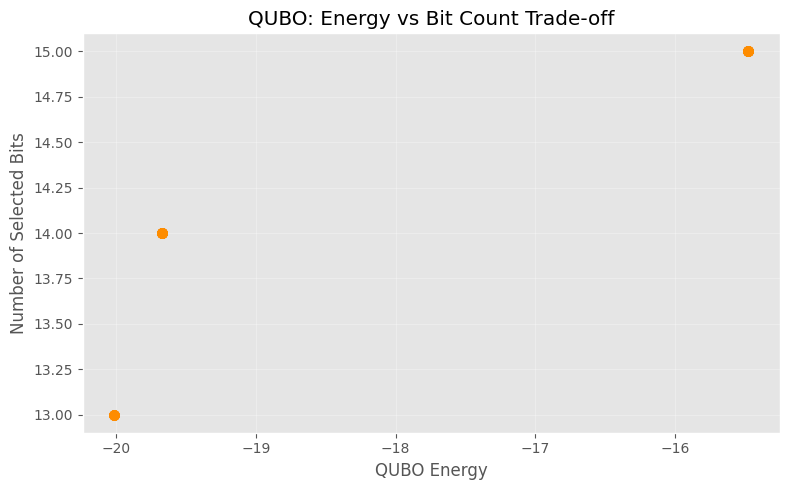

In [7]:
# Visualize QUBO front
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(qubo_result.F[:, 0], -qubo_result.F[:, 1], s=50, alpha=0.7, c='darkorange')
ax.set_xlabel("QUBO Energy")
ax.set_ylabel("Number of Selected Bits")
ax.set_title("QUBO: Energy vs Bit Count Trade-off")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Permutation Encoding

Permutation variables represent orderings. Common operators:
- **Crossover**: Order crossover (OX), PMX, cycle crossover
- **Mutation**: Swap, inversion, scramble

### 2.1 Traveling Salesman Problem (TSP)

In [8]:
# Create TSP problem with 6 cities
tsp_small = TSPProblem(n_cities=6)

print(f"Problem: Traveling Salesman (TSP)")
print(f"  Variables: {tsp_small.n_var} cities (permutation order)")
print(f"  Objectives:")
print(f"    - f1: Total tour length (minimize)")
print(f"    - f2: Maximum edge length (minimize)")
print(f"  Encoding: {tsp_small.encoding}")
print(f"\nCity coordinates:")
for i, (x, y) in enumerate(tsp_small.coordinates):
    print(f"  City {i}: ({x:.2f}, {y:.2f})")

Problem: Traveling Salesman (TSP)
  Variables: 6 cities (permutation order)
  Objectives:
    - f1: Total tour length (minimize)
    - f2: Maximum edge length (minimize)
  Encoding: permutation

City coordinates:
  City 0: (1.00, 0.00)
  City 1: (0.50, 0.87)
  City 2: (-0.50, 0.87)
  City 3: (-1.00, 0.00)
  City 4: (-0.50, -0.87)
  City 5: (0.50, -0.87)


In [9]:
# Configure NSGA-II for permutation encoding
perm_config = (
    NSGAIIConfig()
    .pop_size(50)
    .crossover("ox", prob=0.9)  # Order crossover
    .mutation("swap", prob=0.2)  # Swap mutation
    .selection("tournament", pressure=2)
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

# Run optimization
tsp_result = optimize(OptimizeConfig(
    problem=tsp_small,
    algorithm="nsgaii",
    algorithm_config=perm_config,
    termination=("n_eval", 2000),
    seed=42,
))

print(f"Found {len(tsp_result.F)} Pareto-optimal tours")

Found 50 Pareto-optimal tours


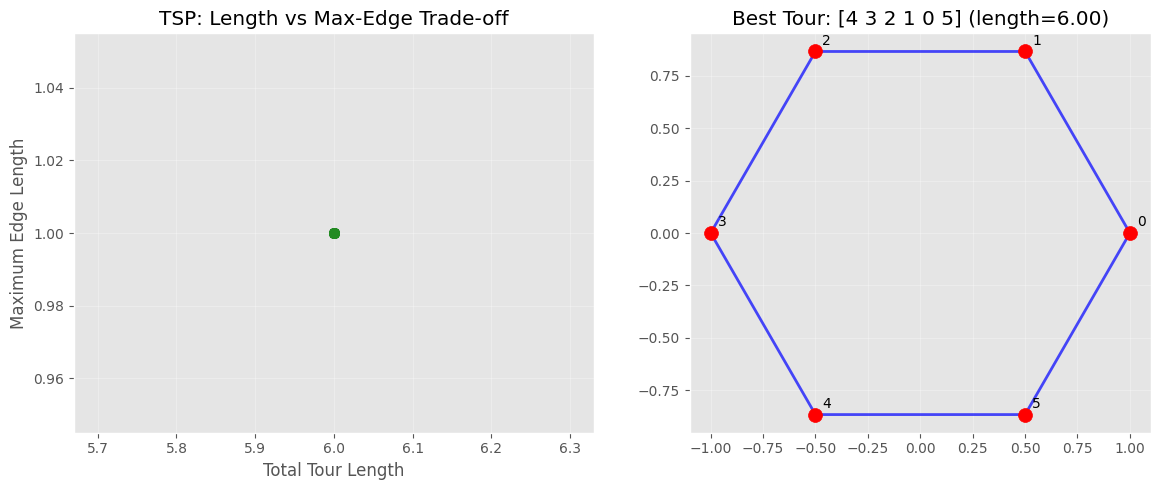

In [10]:
# Visualize TSP trade-off
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Pareto front
axes[0].scatter(tsp_result.F[:, 0], tsp_result.F[:, 1], s=50, alpha=0.7, c='forestgreen')
axes[0].set_xlabel("Total Tour Length")
axes[0].set_ylabel("Maximum Edge Length")
axes[0].set_title("TSP: Length vs Max-Edge Trade-off")
axes[0].grid(True, alpha=0.3)

# Right: Best tour visualization
best_idx = np.argmin(tsp_result.F[:, 0])  # Shortest total length
tour = tsp_result.X[best_idx].astype(int)
coords = tsp_small.coordinates

# Plot cities
axes[1].scatter(coords[:, 0], coords[:, 1], s=100, c='red', zorder=5)
for i, (x, y) in enumerate(coords):
    axes[1].annotate(f'{i}', (x, y), xytext=(5, 5), textcoords='offset points')

# Plot tour
tour_coords = coords[tour]
tour_coords = np.vstack([tour_coords, tour_coords[0]])  # Close the loop
axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'b-', linewidth=2, alpha=0.7)
axes[1].set_title(f"Best Tour: {tour} (length={tsp_result.F[best_idx, 0]:.2f})")
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Larger TSP Instance (TSPLIB)

In [11]:
# Load TSPLIB instance via registry (if available)
try:
    selection = make_problem_selection("tsplib_kroa100")
    tsp_large = selection.instantiate()
    print(f"Loaded TSPLIB KroA100: {tsp_large.n_var} cities")
    has_tsplib = True
except Exception as e:
    print(f"TSPLIB not available: {e}")
    print("Using synthetic 20-city problem instead.")
    tsp_large = TSPProblem(n_cities=20)
    has_tsplib = False

TSPLIB not available: "Unknown problem 'tsplib_kroa100'."
Using synthetic 20-city problem instead.


In [12]:
# Run on larger instance (reduced budget for demo)
large_config = (
    NSGAIIConfig()
    .pop_size(100)
    .crossover("ox", prob=0.9)
    .mutation("swap", prob=0.3)
    .selection("tournament", pressure=2)
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

tsp_large_result = optimize(OptimizeConfig(
    problem=tsp_large,
    algorithm="nsgaii",
    algorithm_config=large_config,
    termination=("n_eval", 5000),
    seed=42,
))

print(f"Found {len(tsp_large_result.F)} Pareto-optimal tours")
print(f"Best total length: {tsp_large_result.F[:, 0].min():.2f}")
print(f"Best max edge: {tsp_large_result.F[:, 1].min():.2f}")

Found 6 Pareto-optimal tours
Best total length: 6.87
Best max edge: 0.62


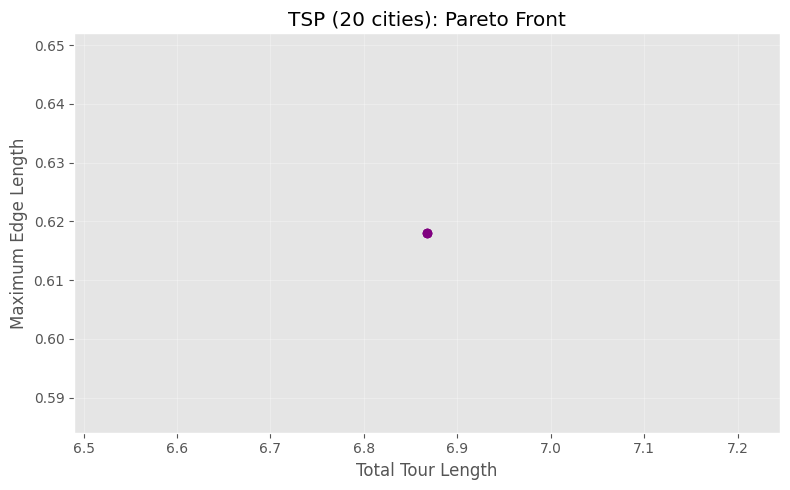

In [13]:
# Visualize larger TSP front
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(tsp_large_result.F[:, 0], tsp_large_result.F[:, 1], s=40, alpha=0.7, c='purple')
ax.set_xlabel("Total Tour Length")
ax.set_ylabel("Maximum Edge Length")
ax.set_title(f"TSP ({tsp_large.n_var} cities): Pareto Front")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Operator Summary

### Binary Operators

In [14]:
# Demonstrate binary operators
print("Binary Crossover Options:")
print("  - 'uniform': Each bit from random parent")
print("  - 'one_point': Single crossover point")
print("  - 'two_point': Two crossover points")
print()
print("Binary Mutation Options:")
print("  - 'bitflip': Flip bits with probability")
print()

# Example config
binary_example = (
    NSGAIIConfig()
    .crossover("uniform", prob=0.9)
    .mutation("bitflip", prob=0.05)  # or "1/n" for adaptive
    .fixed()
)
print(f"Example config: crossover={binary_example.crossover}, mutation={binary_example.mutation}")

Binary Crossover Options:
  - 'uniform': Each bit from random parent
  - 'one_point': Single crossover point
  - 'two_point': Two crossover points

Binary Mutation Options:
  - 'bitflip': Flip bits with probability



ValueError: NSGA-II configuration missing required fields: pop_size, selection, survival, engine

### Permutation Operators

In [ ]:
print("Permutation Crossover Options:")
print("  - 'ox': Order crossover (preserves relative order)")
print("  - 'pmx': Partially-mapped crossover")
print()
print("Permutation Mutation Options:")
print("  - 'swap': Swap two random positions")
print("  - 'inversion': Reverse a random segment")
print("  - 'scramble': Shuffle a random segment")
print()

# Example config
perm_example = (
    NSGAIIConfig()
    .crossover("ox", prob=0.9)
    .mutation("swap", prob=0.2)
    .fixed()
)
print(f"Example config: crossover={perm_example.crossover}, mutation={perm_example.mutation}")

## 4. Compare All Discrete Problems

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Knapsack
axes[0].scatter(knapsack_result.F[:, 0], -knapsack_result.F[:, 1], s=30, alpha=0.7, c='steelblue')
axes[0].set_xlabel("Capacity Deviation")
axes[0].set_ylabel("Total Value")
axes[0].set_title("Binary Knapsack")
axes[0].grid(True, alpha=0.3)

# QUBO
axes[1].scatter(qubo_result.F[:, 0], -qubo_result.F[:, 1], s=30, alpha=0.7, c='darkorange')
axes[1].set_xlabel("QUBO Energy")
axes[1].set_ylabel("Selected Bits")
axes[1].set_title("Binary QUBO")
axes[1].grid(True, alpha=0.3)

# TSP
axes[2].scatter(tsp_result.F[:, 0], tsp_result.F[:, 1], s=30, alpha=0.7, c='forestgreen')
axes[2].set_xlabel("Tour Length")
axes[2].set_ylabel("Max Edge")
axes[2].set_title("Permutation TSP")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

| Encoding | Variables | Crossover | Mutation | Example Problems |
|----------|-----------|-----------|----------|------------------|
| Binary | 0/1 | uniform, one_point, two_point | bitflip | Knapsack, QUBO, feature selection |
| Permutation | Ordered sequence | ox, pmx | swap, inversion, scramble | TSP, scheduling, routing |
| Integer | Discrete numeric | sbx (with repair) | pm (with rounding) | Design variables, resource allocation |

**Key points:**
- Choose operators matching your encoding type
- Binary: `uniform` crossover + `bitflip` mutation work well
- Permutation: `ox` crossover + `swap` mutation preserve validity
- Mutation probability ~0.05-0.1 for binary, ~0.2-0.3 for permutation
- VAMOS automatically validates permutations remain valid